# RBA Selected Tables

Worth reading

*  [Updates to Australia's Financial Aggregates](https://www.rba.gov.au/publications/bulletin/2019/mar/updates-to-australias-financial-aggregates.html)

## Set-Up

In [1]:
# standard library imports
from pathlib import Path

# usual data science imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# local imports
import rba_data_capture
from plotting import (
    clear_chart_dir,
    finalise_plot,
    line_plot,
    plot_covid_recovery,
    plot_series_highlighted,
    recalibrate_series,
    set_chart_dir,
)

In [3]:
# display charts in notebook
SHOW = False

### Some useful constants

In [4]:
TODAY = pd.Timestamp("today")
TOMORROW = TODAY + pd.DateOffset(days=1)

# multi-time-period charts
YEARS5_PERIOD_Y = 5  # years
YEARS5_PERIOD_M = 3  # months
YEARS5 = TODAY - pd.DateOffset(years=YEARS5_PERIOD_Y, months=YEARS5_PERIOD_M)

CURRENT_CYCLE = pd.Timestamp("2022-04-01")

V_RECENCY_PERIOD = 370  # days
YEARS1 = TODAY - pd.DateOffset(days=V_RECENCY_PERIOD)

VV_RECENCY_PERIOD = 180  # days
MONTHS6 = TODAY - pd.DateOffset(days=VV_RECENCY_PERIOD)

TEN_YEARS = TODAY - pd.DateOffset(years=10)

# Where to put the charts
CHART_DIR = "./CHARTS/RBA"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)

# plotting stuff
plt.style.use("fivethirtyeight")
SOURCE = "Source: RBA"

### List available data tables - but only if needed

In [5]:
NEED_HELP = False
if NEED_HELP:
    print(rba_data_capture.get_data_table_labels())

### Utility functions

In [6]:
def print_last_date(df: pd.DataFrame) -> None:
    """Print the last date index in a DataFrame."""

    print(f"Last date: {df.index[-1]}")

## Monetary Policy - Official Cash Rate (A2)

In [7]:
def plot_cash_rate():
    """Produce official cash rate (OCR) chart."""

    # get the data
    a2_meta, a2_data = rba_data_capture.get_data("Monetary Policy Changes – A2")
    print_last_date(a2_data)

    # extract the cash rate series
    target = "New Cash Rate Target"
    series_id = a2_meta[a2_meta.Title == target].index[0]
    ocr_rba = a2_data[series_id].to_period(freq="D")

    # remove some early target ranges
    ocr_rba = ocr_rba[ocr_rba.index >= "1990-08-02"].astype(float)

    # update the series to today
    today = pd.Period(TODAY, freq="D")
    if today > ocr_rba.index[-1]:
        last = ocr_rba.iloc[-1]
        ocr_rba[today] = last
        ocr_rba = ocr_rba.sort_index()

    # put in every day throughout the series
    new_index = pd.period_range(start=ocr_rba.index.min(), end=ocr_rba.index.max())
    ocr_rba = ocr_rba.reindex(new_index, fill_value=np.nan).ffill()

    # plot full series and recent
    print(ocr_rba.index.dtype)
    ocr_rba = ocr_rba.ffill()
    line_plot(
        ocr_rba,
        starts=["1993-01-01", YEARS5, CURRENT_CYCLE],
        title="RBA Official Cash Rate",
        drawstyle="steps-post",
        ylabel="Per cent",
        zero_y=True,
        rfooter=f"{SOURCE} A2",
        show=True,
    )

    # plot tightening cycles
    from_date = "1993-01-01"  # Start of RBA inflation-targeting approach
    series_93 = ocr_rba[ocr_rba.index >= from_date]
    ax = plot_series_highlighted(series_93)
    finalise_plot(
        ax,
        title="RBA Official Cash Rate - Tightening Cycles",
        ylabel="Per cent",
        rfooter=f"{SOURCE} A2",
        lfooter=f"Right end-point: {series_93.iloc[-1]} per cent. ",
        show=SHOW,
    )

Retrieving data from cache: RBA_CACHE/a296718e2fda7d15d3e636d9aca9c548--a02hist.xls
Last date: 2023-11-08 00:00:00
period[D]


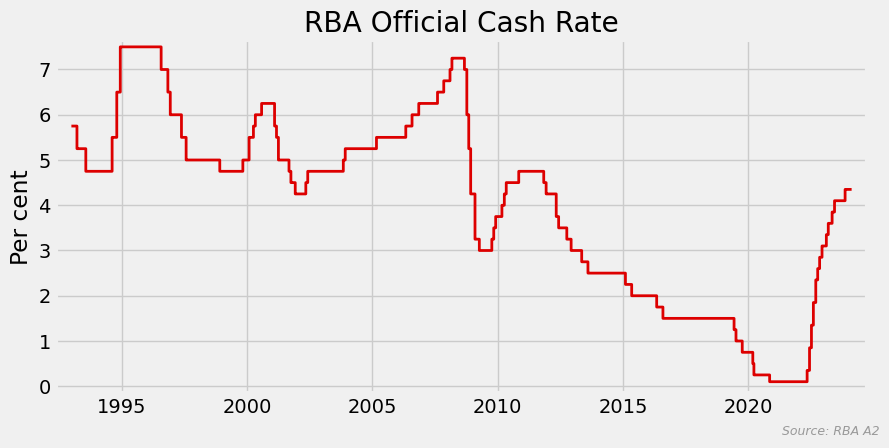

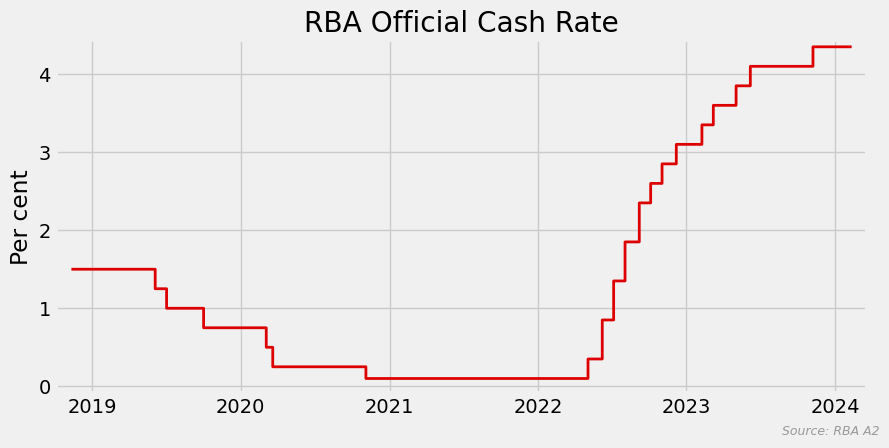

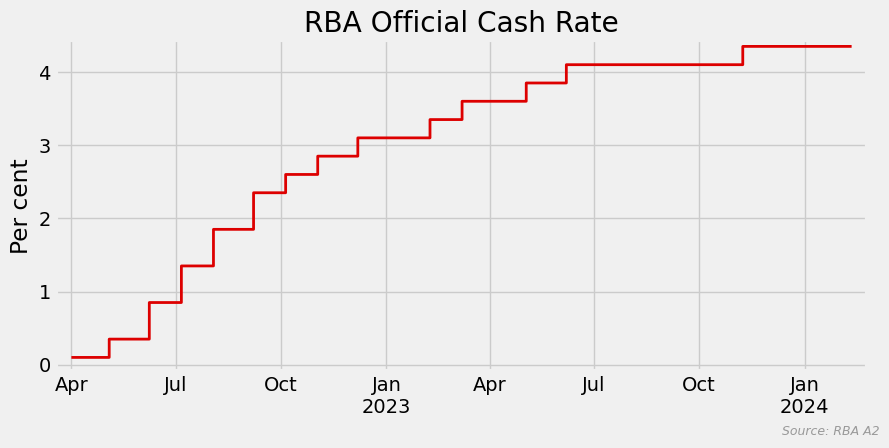

In [8]:
plot_cash_rate()

## Housing Loan Payments (E13)

In [9]:
def housing_repayments():
    """Produce housing loan repayment charts."""

    e13_meta, e13_data = rba_data_capture.get_data("Housing Loan Payments - E13")

    # Note - some data is labeled monthly and some data is labeled quarterly
    freqs = {"Quarterly": "Q", "Monthly": "M"}
    for _, row in e13_meta.iterrows():
        title = row["Title"]
        unit = row["Units"]
        series_id = row["Series ID"]
        series_type = row["Type"]
        freq = freqs[row["Frequency"]]
        series = e13_data[series_id].astype(float).dropna().to_period(freq=freq)
        series, unit = recalibrate_series(series, unit)

        split_title_len = 50  # characters
        if len(title) > split_title_len:
            title = "\n".join(title.rsplit(";", 1))

        line_plot(
            series,
            starts=YEARS5,
            title=title,
            ylabel=unit,
            rfooter=f"{SOURCE} E13",
            lfooter=f"Australia. {series_type}. Endpoint at {series.index[-1]}: "
            f"{series.iloc[-1]:.02f} {unit}. ",
            show=SHOW,
        )

In [10]:
housing_repayments()

Retrieving data from cache: RBA_CACHE/29afb43a70c346a54fd8b1f5051f307f--e13hist.xlsx


## Key market interest rates (F1)

In [11]:
def market_rates():
    """Produce market interest rates charts."""

    # get the dataset
    f1_meta, f1_data = rba_data_capture.get_data(
        "Interest Rates and Yields – Money Market – Daily – F1"
    )
    f1_data = f1_data.to_period(freq="D")
    print_last_date(f1_data)

    # get the specific data we want, for the very recent past
    wanted = [
        "Cash Rate Target",
        #'Interbank Overnight Cash Rate',
        "EOD 1-month BABs/NCDs",
        # '1-month OIS',  # discontinued December 2022
        # '1-month Treasury Note',
    ]
    series_ids = [f1_meta[f1_meta.Title == x].index[0] for x in wanted]
    plotable_data = (
        f1_data[series_ids]
        .rename(dict(zip(series_ids, wanted)), axis=1)
        .dropna(how="all", axis=1)
        .dropna(how="all", axis=0)
        # .ffill()
        .infer_objects(copy=False)
    )

    # And plot
    title = "Australia - short-term Interest rates"
    line_plot(
        plotable_data,
        starts=CURRENT_CYCLE,
        title=title,
        drawstyle="steps-post",
        ylabel="Per cent",
        rfooter=f"{SOURCE} F1 Daily",
        lfooter="Key: EOD = end of day; "
        "BABs/NCDs = Bank Accepted Bills / Negotiable Certificates of Deposit.",
        show=SHOW,
    )

In [12]:
market_rates()

Retrieving data from cache: RBA_CACHE/8c1db91fee0d8c426c22e84c78607de2--f01d.xls
Last date: 2024-02-09


## Australian Government Bonds (F2)

### Utility functions

In [13]:
def get_bonds(meta, data):
    """Get Bonds data."""

    bond_yield = meta[
        meta.Title.str.contains("Australian|Commonwealth")
        & meta.Title.str.contains("year")
    ]
    bond_yield_labels = bond_yield.Title.str.replace(
        "Australian Government ", ""
    ).str.replace("Commonwealth Government ", "")
    bond_yield_data = data[bond_yield_labels.index]
    bond_yield_data.columns = bond_yield_labels

    return bond_yield_data

In [14]:
def plot_yields(data, period, table, show=SHOW):
    """Plot full series and recent."""

    title = "Capital Market Yields - Australian Government Bonds"
    line_plot(
        data,
        starts=[None, MONTHS6],
        tags=f"{table}-{period}",
        width=1,
        drawstyle="steps-post",
        title=title,
        ylabel="Per cent per annum",
        rfooter=f"{SOURCE} {table} {period}",
        show=show,
    )

In [15]:
def inversion_plot(data, lo, hi, bonds_daily, show=SHOW):
    """Plot bond rate inversions, ehere they occur."""

    t_lo = f"{lo} year bond"
    t_hi = f"{hi} year bond"

    inversions = bonds_daily[t_hi] - bonds_daily[t_lo]
    inversions = -inversions.where(inversions < 0, other=0)
    line_plot(
        inversions,
        starts=[None, MONTHS6],
        title=f"Capital Market Yield Inversions [({hi}-year - {lo}-year) * -1]",
        ylabel="% points difference",
        rfooter=f"{SOURCE} F2 Daily",
        lfooter=f"Australian Government Bonds. Data up to {data.index[-1]}. ",
        show=show,
    )

In [16]:
def bonds():
    """Produce bond market plots."""

    f2_meta, f2_data = rba_data_capture.get_data(
        "Capital Market Yields – Government Bonds – Daily – F2"
    )
    f2_data = f2_data.to_period(freq="D")
    print_last_date(f2_data)
    bonds_daily = get_bonds(f2_meta, f2_data)
    plot_yields(bonds_daily, "Daily", "F2")
    inversion_plot(f2_data, 2, 3, bonds_daily)
    inversion_plot(f2_data, 2, 5, bonds_daily)
    inversion_plot(f2_data, 2, 10, bonds_daily)

In [17]:
bonds()

Retrieving data from cache: RBA_CACHE/574cf749ae26907eb91a59465ebe33b8--f02d.xlsx
Last date: 2024-02-07


## Growth in credit aggregates (D1)

In [18]:
def credit_aggregates():
    """Produce credit aggregate charts."""

    data_label = "Growth in Selected Financial Aggregates – D1"
    d1_meta, d1_data = rba_data_capture.get_data(data_label)
    d1_data = d1_data.to_period(freq="M")
    print_last_date(d1_data)

    chart_set = [
        "Credit; Housing; Monthly growth",
        "Credit; Owner-occupier housing; Monthly growth",
        "Credit; Investor housing; Monthly growth",
        "Credit; Other personal; Monthly growth",
        "Credit; Business; Monthly growth",
        "Credit; Total; Monthly growth",
    ]

    for label in chart_set:
        name = d1_meta[d1_meta.Title == label].index[0]
        series_type = d1_meta[d1_meta.Title == label].Type.iloc[0]
        series = d1_data[name]

        line_plot(
            series,
            starts=[None, YEARS5],
            y0=True,
            title=label,
            ylabel="Per cent",
            rfooter=f"{SOURCE} D1",
            lfooter=series_type,
            show=SHOW,
        )

In [19]:
credit_aggregates()

Retrieving data from cache: RBA_CACHE/6db07bfe9b2daee1ef6cc78d5f5839a9--d01hist.xlsx
Last date: 2023-12


## Money supply (D3)

In [20]:
def money_supply():
    """Produce money supply charts."""

    # data capture
    term = "Monetary Aggregates – D3"
    d3_meta, d3_data = rba_data_capture.get_data(term)
    d3_data = d3_data.to_period(freq="M")
    print_last_date(d3_data)

    # plot Money Supply
    to_get = ["Currency: Seasonally adjusted", "Money base", "M1", "M3", "Broad money"]
    gotten = {t: d3_data[d3_meta[d3_meta.Title == t].index[0]] for t in to_get}
    m_units = {t: d3_meta[d3_meta["Title"] == t].Units.iloc[0] for t in to_get}

    for title, series in gotten.items():
        series = series.dropna().astype(float)
        series, m_unit = recalibrate_series(series, m_units[title])
        series.name = title
        chart_title = f"{title} - Money Supply"

        aux_kwargs = {}
        aux_kwargs["start_r"], aux_kwargs["end_r"] = (
            ("2016-05-01", "2019-05-01")
            if title == "M1"
            else ("2017-01-01", "2020-01-01")
        )

        plot_covid_recovery(
            series,
            **aux_kwargs,
            title=chart_title,
            tags="COVID",
            ylabel=m_unit,
            rfooter=f"{SOURCE} D3",
            show=SHOW,
        )

        line_plot(
            series,
            starts=[None, TEN_YEARS],
            title=chart_title,
            ylabel=m_unit,
            rfooter=f"{SOURCE} D3",
            show=SHOW,
        )

        line_plot(
            series,
            starts=[None, TEN_YEARS],
            title=chart_title,
            ylabel=f"{m_unit} (log scale)",
            rfooter=f"{SOURCE} D3",
            yscale="log",
            show=SHOW,
        )

In [21]:
money_supply()

Retrieving data from cache: RBA_CACHE/3bb444ebe3112807ffaf2dbf157edeb6--d03hist.xlsx
Last date: 2023-12


## Watermark

In [22]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sun Feb 11 2024 11:27:53

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

pandas    : 2.2.0
numpy     : 1.26.4
matplotlib: 3.8.2

Watermark: 2.4.3



In [23]:
print("Done")

Done
